In [3]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import pickle
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

from scipy.sparse import csc_matrix, coo_matrix, hstack

from scipy.stats import pearsonr, spearmanr


In [4]:
np.ceil(100.1).astype(int)

101

In [5]:
# Initialize WD
root_folder = "/cjc/miel/martin/WLMT-recapitulation"
results_folder = f"{root_folder}/data/results/results_10102023"
# results_folder = f"{root_folder}/data/results/results_10122023"
output_folder = f"{results_folder}/analysis_result"
os.makedirs(output_folder, exist_ok=True)


In [25]:
meer_regstats = np.load(f'{output_folder}/meer_regstats.npy', allow_pickle=True)

In [29]:
pca_expl_var = np.load(f"{output_folder}/pca_explained_variance_ratio_0.01propnan_filtered.npy", allow_pickle=True)

In [30]:
pc_corr = pd.read_csv(f"{output_folder}/meer_pca_weights_corr_0.01propnan_filtered.csv", index_col=0)

In [31]:
pc_corr.abs().sort_values(by="pearsonr", ascending=False).iloc[:10]

,pearsonr,pval,spearmanr,pval.1,shared_weights
PC7,0.521653,9.980745e-32,0.539112,3.645205e-34,435.0
PC9,0.463119,1.643515e-24,0.487997,2.078418e-27,435.0
PC12,0.434169,2.005619e-21,0.400009,3.819256e-18,435.0
PC10,0.389645,3.196379e-17,0.412610,2.603412e-19,435.0
PC44,0.378564,2.855891e-16,0.373783,7.163074e-16,435.0
PC8,0.376555,4.210960e-16,0.326628,2.843379e-12,435.0
PC21,0.374353,6.423828e-16,0.376132,4.568195e-16,435.0
PC1,0.331775,1.229987e-12,0.377693,3.380902e-16,435.0
PC30,0.331631,1.259542e-12,0.331014,1.393710e-12,435.0
PC32,0.318023,1.114275e-11,0.316089,1.505629e-11,435.0


In [32]:
pca_wmeta = pd.read_csv(f"{output_folder}/pca_wmeta_0.01propnan_filtered.csv")

In [33]:
meer_metage = pd.read_csv(f"{output_folder}/meer_metage.csv")

In [34]:
pca_wmeta = pca_wmeta.merge(meer_metage, on="run")

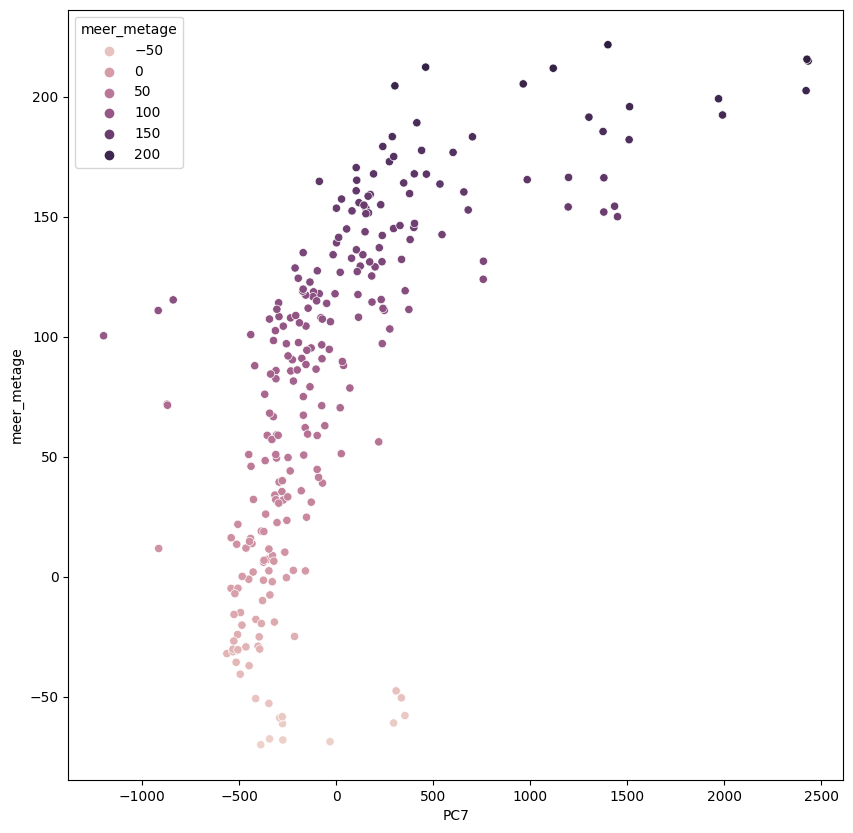

In [38]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
fig = sns.scatterplot(
    x="PC7", 
    y="meer_metage",
    hue="meer_metage",
    data=pca_wmeta,
    ax=ax
    )
# x1, x2 = pca_wmeta["PC30"].quantile([0.01, 0.99])
# plt.xlim(x1,x2)
# plt.savefig(
#     f"{output_folder}/pc1_meermetage_propnan_filtered.png",
#     dpi=300,
#     bbox_inches="tight",
# )


In [7]:
pca_explained_variance_ratio = np.load(f"{output_folder}/pca_explained_variance_ratio_0.01propnan_filtered.npy")

In [21]:
plot_data = pca_explained_variance_ratio[:20]

<AxesSubplot:>

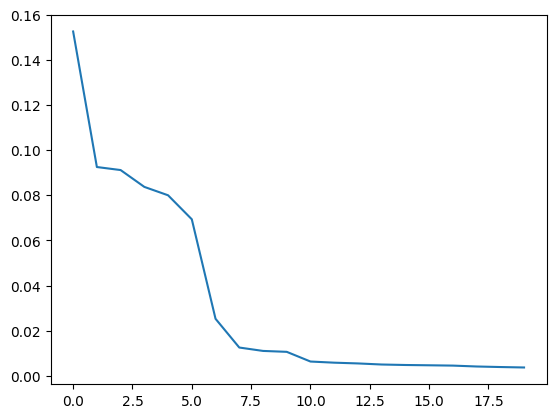

In [22]:
sns.lineplot(y=plot_data, x=np.arange(plot_data.shape[0]))

In [24]:
pd.read_csv(f"{output_folder}/metage_explained_variance_ratio_0.01propnan_filtered.csv", header=None)


,0,1
0,NaN,0.000000
1,meer_metage,0.000431
2,pet_metage,0.000171


In [13]:
import sklearn.decomposition._pca as pca
pca2 = joblib.load(f"{output_folder}/pca_0.01propnan_filtered.joblib")
# joblib.load(f"{output_folder}/pca.joblib")

ModuleNotFoundError: No module named 'sklearn.decomposition.pca'

In [17]:
prop_nan = pd.read_csv(f"{output_folder}/prop_nan.csv", index_col=0)

In [20]:
prop_nan[prop_nan <= 0.05]

,0
index,
9_77838718,NaN
5_22746367,0.015748
3_84314889,NaN
11_101350756,NaN
2_157915024,NaN
...,...
18_57791379,NaN
11_99024129,NaN
14_61580001,NaN


In [55]:
import os
files = pd.Series(os.listdir(f"{output_folder}/pca_0.01propnan_filtered_16sample"))

In [56]:
metage_explained_variance_ratio = files[files.str.contains("metage_explained_variance_ratio_0.01propnan_filtered_16sample_boot")]
meta = pd.concat([metage_explained_variance_ratio, metage_explained_variance_ratio.str.extract("boot(\d+)")[0].astype(int)], axis=1)

In [57]:
metage_explained_variance_ratio

5      metage_explained_variance_ratio_0.01propnan_fi...
14     metage_explained_variance_ratio_0.01propnan_fi...
18     metage_explained_variance_ratio_0.01propnan_fi...
24     metage_explained_variance_ratio_0.01propnan_fi...
27     metage_explained_variance_ratio_0.01propnan_fi...
                             ...                        
943    metage_explained_variance_ratio_0.01propnan_fi...
950    metage_explained_variance_ratio_0.01propnan_fi...
951    metage_explained_variance_ratio_0.01propnan_fi...
960    metage_explained_variance_ratio_0.01propnan_fi...
970    metage_explained_variance_ratio_0.01propnan_fi...
Length: 100, dtype: object

In [61]:
with ThreadPoolExecutor() as excecutor:
    futures = [excecutor.submit(pd.read_csv, f"{output_folder}/pca_0.01propnan_filtered_16sample/{f}") for f in metage_explained_variance_ratio]
    data = []
    for future in tqdm(as_completed(futures), total=len(futures)):
        data.append(future.result())
expl_v = pd.concat(data, axis=0)

100%|██████████| 100/100 [00:00<00:00, 173246.76it/s]


In [64]:
expl_v.groupby("Unnamed: 0").mean()

,0
Unnamed: 0,
meer_metage,0.000736
pet_metage,0.000289


In [66]:
expl_v.groupby("Unnamed: 0").std()

,0
Unnamed: 0,
meer_metage,0.000424
pet_metage,0.000179


In [ ]:
expl_v.groupby("Unnamed: 0").median

In [74]:
expl_v.groupby("Unnamed: 0").quantile([0.99, 0.5, 0.01])*100

0
Unnamed: 0                
meer_metage 0.99  0.149118
            0.50  0.081343
            0.01  0.011943
pet_metage  0.99  0.062625
            0.50  0.030303
            0.01  0.003483

In [70]:
expl_v.groupby("Unnamed: 0").max()

,0
Unnamed: 0,
meer_metage,0.001539
pet_metage,0.000629


In [71]:
expl_v.var()

/home/martinak/anaconda3/envs/WLMT/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


0    1.555673e-07
dtype: float64

In [ ]:
np.var()